In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.gridspec as gridspec

In [ ]:
import scipy

In [ ]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1) Empirical divergence correlations and their 95% confidence interval

In [ ]:
# Function to compute the confidence interval on spearman rho
def spearman_ci(x, y, ci=95, n_boots=10000, seed=22):
  x = np.asarray(x)
  y = np.asarray(y)

  # (n_boots, n_observations) paired arrays
  rng = np.random.default_rng(seed) # For reproducible bootstrapping
  rand_ixs = rng.integers(0, x.shape[0], size=(n_boots, x.shape[0]))
  x_boots = x[rand_ixs]
  y_boots = y[rand_ixs]

  # Spearman correlations
  corrs = []

  for row in range(x_boots.shape[0]):
    rho = stats.spearmanr(x_boots[row, :], y_boots[row, :])
    corrs.append(rho[0])

  # Quantiles of correlations coefficients and confidence interval
  corrs = np.asarray(corrs)

  ci_low = np.percentile(corrs, (100 - ci) / 2)
  ci_high = np.percentile(corrs, (ci + 100) / 2)

  return ci_low, ci_high, corrs

First for the correlation between the magnitudes of transcriptional and translational divergence

In [ ]:
# Empirical divergence data is imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                                 'Final_figures/Data_sim_ready/'
                                 'couples_divergence.csv')

# Only WGD-derived pairs are kept
couples_divergence = couples_divergence[couples_divergence['Duplication'] == 'WGD'].reset_index(drop=True)

In [ ]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['bm_fold_original'],
                      couples_divergence['bp_fold_original'])
spearman_ci_div = (rho_emp[0], rho_emp[1])
dist_boot_div = rho_emp[2]

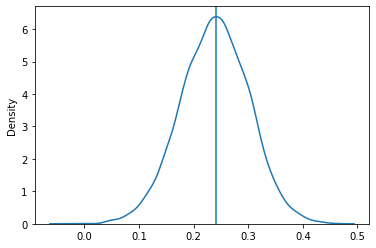

In [ ]:
# Quick validation that bootstrapping is valid:
center_div = stats.spearmanr(couples_divergence['bm_fold_original'],
                         couples_divergence['bp_fold_original'])[0]

sns.kdeplot(dist_boot_div)
plt.axvline(x=center_div)

The 95% confidence interval is also computed for the signed divergence correlation:

In this case, a duplicated dataset is used, so that logfold changes are computed in the two possible orientations for each paralog pair

In [ ]:
couples_divergence['bm_fold_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['bp_fold_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['bm_fold_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['bp_fold_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))

In [ ]:
logfold_dupli_1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_1', 'bp_fold_signed_1']].copy()

logfold_dupli_1.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']


logfold_dupli_2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_2', 'bp_fold_signed_2']].copy()

logfold_dupli_2.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']

logfold_dupli = pd.concat([logfold_dupli_1, logfold_dupli_2])

In [ ]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(logfold_dupli['bm_fold_signed'],
                      logfold_dupli['bp_fold_signed'])
spearman_ci_sign = (rho_emp[0], rho_emp[1])
dist_boot_sign = rho_emp[2]

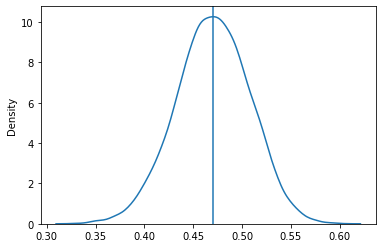

In [ ]:
# Quick validation that bootstrapping is valid:
center_sign = stats.spearmanr(logfold_dupli['bm_fold_signed'],
                              logfold_dupli['bp_fold_signed'])[0]

sns.kdeplot(dist_boot_sign)
plt.axvline(x=center_sign)

## 2) Importing simulated correlations for a range of duplication effects

In [ ]:
corrs_dupli = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Sims_dupli_effect/Correlations_all_Dupli_effect.csv')

In [ ]:
# Ignoring the 'True duplicates' calculation
corrs_dupli = corrs_dupli[corrs_dupli['Type'] == 'All'].reset_index(drop=True)

In [ ]:
# Adding a column to keep the post-duplication effect
effect_dict = {'effect_16': 1.6, 'effect_187': 1.87, 'effect_2': 2.0,
               'effect_225': 2.25}

corrs_dupli['Effect'] = np.NaN

for row in range(corrs_dupli.shape[0]):
  corrs_dupli.at[row, 'Effect'] = effect_dict[corrs_dupli.at[row, 'Folder']]

In [ ]:
# Distinct dataframes are made for the two models
corrs_min = corrs_dupli[corrs_dupli['Model'] == 'Minimal'].copy().reset_index(drop=True)
corrs_mixed = corrs_dupli[corrs_dupli['Model'] == 'Mixed'].copy().reset_index(drop=True)

## 3) Construction of the figure

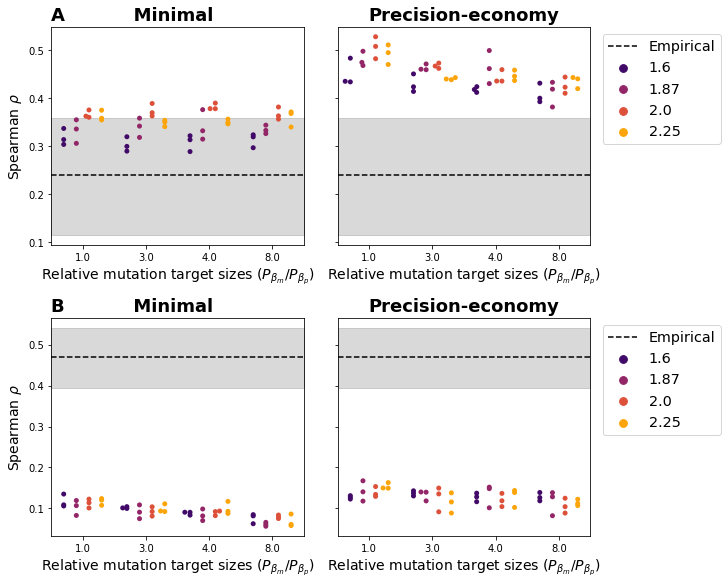

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True,
                        sharey='row')

# First, divergence correlations
sns.swarmplot(x='Mut_ratio', y='rho_fold', hue='Effect', data=corrs_min,
              ax=axs[0,0], palette='inferno', dodge=True)

sns.swarmplot(x='Mut_ratio', y='rho_fold', hue='Effect', data=corrs_mixed,
              ax=axs[0,1], palette='inferno', dodge=True)

for ax in [axs[0,0], axs[0,1]]:
  x_lims = ax.get_xlim()
  ax.axhline(y=center_div, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_div[0], spearman_ci_div[1], 
                  color='black', alpha=0.15)
axs[0,0].legend([],[], frameon=False)
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                 fontsize='x-large')

# Second signed divergence correlations
sns.swarmplot(x='Mut_ratio', y='rho_signed', hue='Effect', data=corrs_min,
              ax=axs[1,0], palette='inferno', dodge=True)

sns.swarmplot(x='Mut_ratio', y='rho_signed', hue='Effect', data=corrs_mixed,
              ax=axs[1,1], palette='inferno', dodge=True)

for ax in [axs[1,0], axs[1,1]]:
  x_lims = ax.get_xlim()
  ax.axhline(y=center_sign, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_sign[0], spearman_ci_sign[1], 
                  color='black', alpha=0.15)

axs[1,0].legend([],[], frameon=False)
axs[1, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                 fontsize='x-large')
# Axes labels
for ax in [axs[0,0], axs[1,0]]:
  ax.set_ylabel(r"Spearman $\rho$", fontsize=14)

for ax in [axs[0,1], axs[1,1]]:
  ax.set_ylabel('')

for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
  ax.set_xlabel(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
                fontsize=14)
  
# Titles
axs[0,0].set_title('A           Minimal', loc='left', fontsize=18, fontweight="bold")
axs[1,0].set_title('B           Minimal', loc='left', fontsize=18, fontweight="bold")

axs[0,1].set_title('Precision-economy', loc='center', fontsize=18, fontweight="bold")
axs[1,1].set_title('Precision-economy', loc='center', fontsize=18, fontweight="bold")

# Saving the figure
FigS9 = plt.gcf()
FigS9.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/'
              'FigS9.tiff', bbox_inches='tight')